In [63]:
import numpy as np
import pandas as pd
from __future__ import division
import time
from random import shuffle
import xmltodict
import json
import collections
from collections import Counter
import matplotlib.pyplot as plt
import pprint
import nltk
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.feature_extraction.text import *
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix

from gensim.models import LdaModel
from gensim.corpora import Dictionary

# view all columns of pandas df
pd.set_option('display.max_columns', None)

# nltk.download('wordnet')      # download wordnet if it's not already downloaded
# nltk.download('averaged_perceptron_tagger')

with open ("dreambank-public.xml") as f:
    doc = xmltodict.parse(f.read())

def convert(data):
    if isinstance(data, basestring):
        return str(data)
    elif isinstance(data, collections.Mapping):
        return dict(map(convert, data.iteritems()))
    elif isinstance(data, collections.Iterable):
        return type(data)(map(convert, data))
    else:
        return data

def left(s, amount):
    return s[:amount]

def right(s, amount):
    return s[-amount:]

def mid(s, offset, amount):
    return s[offset:offset+amount]

# Exploratory Analysis

First we want to print the data to see which fields we are given and how the data looks.

In [64]:
#==================================================================
# Cell Purpose: EDA
#               print the fields from the dreambank collection
# Flags: None in cell
#==================================================================

for dreamer in doc['dreambank']['collection']:
    print dreamer['name'] + ' (' + str(len(dreamer['dream'][:])) + ' dreams)' 
    print '  ID: ' + dreamer['id']
    print '  type: ' + dreamer['type']
    print '  sex: ' + dreamer['sex']
    print '  age: ' + dreamer['age']
    
    try:
        print '  time: ' + dreamer['time']
    except:
        pass
    
    print '  sample dream: ' 
    
    odict = dreamer['dream'][0]
    for key, value in odict.items():
        if convert(key) == 'report':
            print '    report: ' + left(convert(value), 200) + '...'
        else:
            print '    ' + convert(key) + ': ' + str(convert(value))
        
    print '\n'

Alta: a detailed dreamer (422 dreams)
  ID: alta
  type: series
  sex: F
  age: A
  time: 1985-1997
  sample dream: 
    number: 1
    date: 1957
    report: The one at the Meads's house, where it's bigger inside than out; there's a European village just inside, with a cobblestone street and a Pied-Piper sort of man with curly hair, he can do things like j...


Angie: age 18 & 20 (48 dreams)
  ID: angie
  type: series
  sex: F
  age: Y
  time: 1996
  sample dream: 
    number: 1-01
    date: 1996-04-03
    report: My memory of this dream is vague. I think the setting is on a college campus. I'm in a cafe and two elderly ladies walk in and start talking to me about a university that a guy I am dating got into fo...


Arlie: a middle-aged woman (212 dreams)
  ID: arlie
  type: series
  sex: F
  age: A
  time: 1992-1998
  sample dream: 
    number: 1
    date: 10/14/92
    report: I am in an office in the town next to the town I grew up in. Everyone is taking a rest. I have to go to the b

In [65]:
#==================================================================
# Cell Purpose: EDA
#               Print the number of dreams per deramer
#               Print the w266 ID 
#                   Note:  w266ID starts counting at 1, not 0
# Flags: None in cell
#==================================================================
print '---Dream collections from individuals---' + '\n'
MultIDs = ['b', 'madeline1-hs', 'madeline2-dorms', 'madeline3-offcampus', 'phil1', 'phil2', 'vietnam_vet']
NumberOfSeries = 1

for dreamer in doc['dreambank']['collection']:
    if dreamer['type'] == 'series':
        print '{' + dreamer['id']  + '} ' + dreamer['name'] + ' (' + str(len(dreamer['dream'][:])) + ' dreams)' + ' [' + dreamer['sex'] + ']'    
        dreamer['w266ID'] = NumberOfSeries
        
        # Assign a dreamer ID that groups the same dreamers together 
        # and skips the dream collections of multiple dreamers
        print 'w266 ID: ' + str(dreamer['w266ID'])
        if dreamer['id'] not in MultIDs:
            print '\n'
            NumberOfSeries += 1
    else:
        dreamer['w266ID'] = 0
        
print "Total Number of individuals to test vs. 'others': " + str(NumberOfSeries - 1)

---Dream collections from individuals---

{alta} Alta: a detailed dreamer (422 dreams) [F]
w266 ID: 1


{angie} Angie: age 18 & 20 (48 dreams) [F]
w266 ID: 2


{arlie} Arlie: a middle-aged woman (212 dreams) [F]
w266 ID: 3


{b} Barb Sanders (3116 dreams) [F]
w266 ID: 4
{b2} Barb Sanders #2 (1138 dreams) [F]
w266 ID: 4


{bosnak} Robert Bosnak: A dream analyst (53 dreams) [M]
w266 ID: 5


{chris} Chris: a transvestite (100 dreams) [M]
w266 ID: 6


{chuck} Chuck: a physical scientist (75 dreams) [M]
w266 ID: 7


{dahlia} Dahlia: concerns with appearance (24 dreams) [F]
w266 ID: 8


{david} David: teenage dreams (166 dreams) [M]
w266 ID: 9


{dorothea} Dorothea: 53 years of dreams (900 dreams) [F]
w266 ID: 10


{ed} Ed: dreams of his late wife (143 dreams) [M]
w266 ID: 11


{edna} Edna: a blind woman (19 dreams) [F]
w266 ID: 12


{elizabeth} Elizabeth: a woman in her 40s (1707 dreams) [F]
w266 ID: 13


{emma} Emma: 48 years of dreams (1521 dreams) [F]
w266 ID: 14


{emmas_husband} Emma's

In [66]:
#==================================================================
# Cell Purpose: EDA
#               Sum total of all dreams
# Flags: None in cell
#==================================================================
DreamNum = 0

for dreamer in doc['dreambank']['collection']:
    for odict in dreamer['dream']:
        for key, value in odict.items():            
            if convert(key) == 'report':
                DreamNum += 1

print "Total Dreams: " + str(DreamNum)

Total Dreams: 26000


# EDA - Reduce To Noun-Only And Lemmatize

For our topic modeling, we will want to lemmatize the corpus and reduce to nouns-only. However, before we get to topic modeling, it will be helpful to test out the lemmatization and noun-only reduction techniques.

In [67]:
#==================================================================
# Cell Purpose: EDA
#               Explore Lemmatiziation
#               Explore Reduction to Nouns Only
# Libraries: WordNetLemmatizer()
# Flags: None in cell
#==================================================================

# reduce to noun-only and lemmatize
lmtzr = WordNetLemmatizer()

for dreamer in doc['dreambank']['collection']:
    print dreamer['name'] + ' (' + str(len(dreamer['dream'][:])) + ' dreams)' + ' [' + dreamer['sex'] + ']'
    
    print '  noun-only sample dream: ' 
    
    odict = dreamer['dream'][0]
    
    # (1) tokenize dream text
    # (2) tag with PoS
    # (3) reduce to noun-only
    # (4) lemmatize nouns
    # (5) get frequency counts of the lemmatized nouns
    for key, value in odict.items():
        if convert(key) == 'report':
            text = nltk.tokenize.word_tokenize(value)
            pos = nltk.pos_tag(text)
            noun_only = [w[0] for w in pos if w[1].startswith('N')]
            lmtz_noun_only = [lmtzr.lemmatize(word) for word in noun_only]
            counts = Counter(lmtz_noun_only)
            print counts
        
    print '\n'

Alta: a detailed dreamer (422 dreams) [F]
  noun-only sample dream: 
Counter({u'house': 3, u'hair': 2, u'[': 2, u'room': 2, u'bridge': 1, u'set': 1, u'creek': 1, u'people': 1, u'stove': 1, u'one': 1, u'street': 1, u'village': 1, u'corner': 1, u'blonde': 1, u'string': 1, u'pageboy': 1, u'balloon': 1, u'juggle': 1, u'couple': 1, u'sort': 1, u'hallway': 1, u'woman': 1, u'Meads': 1, u'Inside': 1, u'cobblestone': 1, u']': 1, u'man': 1, u'drive': 1, u'round': 1, u'thing': 1, u'aunt': 1, u'side': 1})


Angie: age 18 & 20 (48 dreams) [F]
  noun-only sample dream: 
Counter({u'dream': 3, u'school': 2, u'guy': 2, u'lady': 2, u'hospital': 1, u'information': 1, u'feeling': 1, u'art': 1, u'orientation': 1, u'university': 1, u'cafe': 1, u'setting': 1, u'college': 1, u'memory': 1, u'law': 1, u'campus': 1})


Arlie: a middle-aged woman (212 dreams) [F]
  noun-only sample dream: 
Counter({u'town': 2, u'toilet': 2, u'bathroom': 1, u'Everyone': 1, u'office': 1, u'rest': 1})


Barb Sanders (3116 dreams) [F

# Create Dataframe

In [68]:
#==================================================================
# Cell Purpose:   Wrangle Data into Dataframe
# Data Structure: Panda's DataFrame
# Flags:          None
#==================================================================

# Starting point for Columns/Variables in DataFrame
ID = 0
W266ID = 0
DreamBankID = ''
DreamNumber = ''
Name = ''
Sex = ''
Dream = ''
HasDream = 0

df = pd.DataFrame(columns=["ID", "W266ID", "DreamBankID", "DreamNumber", "Name", "Sex", "Dream"])

for dreamer in doc['dreambank']['collection']:
    Name = dreamer['name'] 
    DreamBankID = dreamer['id']
    W266ID = int(dreamer['w266ID'])
    Sex = dreamer['sex']
    
    for odict in dreamer['dream']:
        HasDream = 0
        for key, value in odict.items():
            if convert(key) == 'report':
                Dream = convert(value)
                HasDream = 1
            if convert(key) == 'number':
                DreamNumber = convert(value)
        
        if HasDream == 1:
            ID += 1
            df = df.append({
                "ID": ID,
                "W266ID": W266ID,
                "DreamBankID": DreamBankID,
                "DreamNumber": DreamNumber,
                "Name": Name,
                "Sex": Sex,
                "Dream": Dream
                }, ignore_index=True)        

# change W266ID from float to integer
df.W266ID = df.W266ID.astype(int)

# print df
print "Total Dreams: " + str(ID)
print "\n"

df.head()

Total Dreams: 26000




,ID,W266ID,DreamBankID,DreamNumber,Name,Sex,Dream
0,1.0,1,alta,1,Alta: a detailed dreamer,F,"The one at the Meads's house, where it's bigge..."
1,2.0,1,alta,2,Alta: a detailed dreamer,F,I'm at a family reunion in a large fine house ...
2,3.0,1,alta,3,Alta: a detailed dreamer,F,I watch a plane fly past and shortly realize i...
3,4.0,1,alta,4,Alta: a detailed dreamer,F,Me pulling the green leaves and berries off so...
4,5.0,1,alta,5,Alta: a detailed dreamer,F,I'm in a room that reminds me of (but definite...


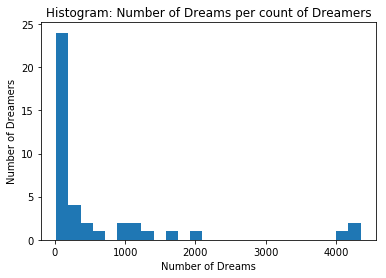

In [69]:
#==================================================================
# Cell Purpose:   EDA of the number of Dreams Per Dreamer
# Data Structure: Plot Histogram
# Flags:          Debug Flag
#==================================================================
# Debug Flag
DEBUG_VERBOSITY_HIGH = False

# create DataFrame for Clarity Sake
numberDreams = pd.DataFrame(df['W266ID'].value_counts())

# Plot DataFrame Inline
%matplotlib inline
plot_df = numberDreams['W266ID'].plot.hist(title = "Histogram: Number of Dreams per count of Dreamers",bins=25)
plot_df.set_xlabel("Number of Dreams")
plot_df.set_ylabel("Number of Dreamers")

#-----------------------
# Debug Print Statements
#-----------------------
if DEBUG_VERBOSITY_HIGH:
    print numberDreams.head()
    type(numberDreams)
    len(df['W266ID'].value_counts())
    print(numberDreams.iloc[0])
    print list(numberDreams.columns.values)
    print numberDreams.describe()


In [9]:
print 'Males: ' + str(len(df[df['Sex']=='M']))
print 'Females: ' + str(len(df[df['Sex']=='F']))
print 'Total: ' + str(len(df))

Males: 7813
Females: 18187
Total: 26000


# Modeling

We want to create a different model for each dreamer (i.e. a classifier identifying one vs all-others for each dreamer). This will allow us to identify the most predictive words in identifying each dreamer.

In [70]:
#==================================================================
# Cell Purpose:  randomly shuffle dataframe
#               set seed for consistency while running
#==================================================================
np.random.seed(0)
df = df.sample(frac=1).reset_index(drop=True)

# add 41 flag columns denoting dreamers (one col per dreamer) 
dreamer_flag = pd.get_dummies(df['W266ID'], prefix='Dreamer')
df = pd.concat([df, dreamer_flag], axis=1)

# create vocab from all dreams
dreams_flat = df['Dream'].values.flatten().tolist()
dreams_list = " ".join(dreams_flat)
vocab = list(set(nltk.tokenize.word_tokenize(dreams_list)))

In [11]:
#==================================================================
# Cell Purpose: Function to split the df into dev, test, train sets
#==================================================================

def split_data(df, W266ID, train=0.6):        
    # column for "our" dreamer
    dreamer_label = 'Dreamer_' + str(W266ID)
    
    # make 60/40 split of train/test
    # test will be evenly split between dev and test in the next step
    num_train = int(len(df) * train)
    num_test = int(len(df) * (1-train)) 

    train_data, train_labels = df['Dream'][:num_train], df[dreamer_label][:num_train]
    dev_data, dev_labels = df['Dream'][-num_test : -num_test//2], df[dreamer_label][-num_test : -num_test//2] 
    test_data, test_labels = df['Dream'][-num_test//2:], df[dreamer_label][-num_test//2:]

    return train_data, train_labels, dev_data, dev_labels, test_data, test_labels

In [12]:
#==================================================================
# Cell Purpose:  EDA
#                Explore dreamer 1 (Alta's) data by creating 1 versus others
#                Create BOW from CountVectorizer
#                Create TFIDF 
#                Run Logistic Regression
# Flag:
#      SHOW_DREAMER_ONE = True 
#           Cell will split the dataset into training, dev, and test sets
#      SHOW_DERAMER_ONE = False 
#           Nothing in the cell will execute
#=============================================================
SHOW_DREAMER_ONE = False 

if SHOW_DREAMER_ONE:
    # # split data for dreamer1 - Alta
    train_data, train_labels, dev_data, dev_labels, test_data, test_labels = split_data(df, W266ID=1)

    ## Create a Bag-of-Words Vectorizer
    vec = CountVectorizer(vocabulary=vocab)
    vec_bow_train_data = vec.fit_transform(train_data)
    vec_bow_dev_data = vec.transform(dev_data)  

    # # Create a Tfidf Vectorizer
    vec_tfidf = TfidfVectorizer(stop_words='english')
    vec_tfidf_train_data = vec_tfidf.fit_transform(train_data)
    vec_tfidf_dev_data   = vec_tfidf.transform(dev_data)

    best_lr_score = 0

    # ## Logistic reg
    for c in (0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 500):
        bow_log = LogisticRegression(C = c)
        bow_log.fit(vec_bow_train_data, train_labels)
    
        tfidf_logit_model = LogisticRegression(C=c)
        tfidf_logit_model.fit(vec_tfidf_train_data, train_labels)
    
        f1_bow_lr_score = metrics.f1_score(dev_labels, bow_log.predict(vec_bow_dev_data), average='macro')    
        f1_tfidf_lr_score = metrics.f1_score(dev_labels, tfidf_logit_model.predict(vec_tfidf_dev_data), average='macro') 

        print 'Logistic Reg:\t C=%3.4f\t BOW: F1-score=%3.3f\t TFIDF: F1-score=%3.3f' % (c, f1_bow_lr_score, f1_tfidf_lr_score)

        if f1_bow_lr_score > best_lr_score:
            best_lr_score = f1_bow_lr_score
            best_C = c 
            vectorizer = 'BOW'
        
        if f1_tfidf_lr_score > best_lr_score:
            best_lr_score = f1_tfidf_lr_score
            best_C = c
            vectorizer = 'TFIDF'

    print ''
    print 'Best model:\t C=%3.4f\t vectorizer = %s\t F1-score=%3.3f' % (best_C, vectorizer, best_lr_score)

## Run a model for each dreamer

We need to run a separate model for each dreamer. The models will predict if a dream comes from that dreamer or from "all-others". Since bag-of-words was working best in the above models, we will continue to use that for our baseline.

In [14]:
#==================================================================
# Cell Purpose:  Run Logisitic Regression for each dreamer
#                This creates a logistic Regression for Each Dreamer
#                with a "one" versus "rest" methodology
#==================================================================
PROGRESSION_PRINTOUTS_ON = True

cell_start = time.time()

models = {}

for i in range(0,41):
    if PROGRESSION_PRINTOUTS_ON:
        print "Progression: Logistic Regression for dreamer ", i
    # split data
    train_data, train_labels, dev_data, dev_labels, test_data, test_labels = split_data(df, W266ID=i)

    # Create a Bag-of-Words Vectorizer
    vec_bow = CountVectorizer(vocabulary=vocab)
    vec_bow_train_data = vec_bow.fit_transform(train_data)
    vec_bow_dev_data = vec_bow.transform(dev_data)  
    
    # Create a TF Vectorizer
    vec_tf = TfidfTransformer(use_idf=False, smooth_idf=False)
    vec_tf_train_data = vec_tf.fit_transform(vec_bow_train_data)
    vec_tf_dev_data   = vec_tf.transform(vec_bow_dev_data)     

    # Create a TF-IDF Vectorizer
    vec_tfidf = TfidfVectorizer(stop_words='english')
    vec_tfidf_train_data = vec_tfidf.fit_transform(train_data)
    vec_tfidf_dev_data   = vec_tfidf.transform(dev_data)    

    ## Logistic reg
    bow_log = LogisticRegression(C = 100)
    bow_log.fit(vec_bow_train_data, train_labels)

    tf_log = LogisticRegression(C = 100)
    tf_log.fit(vec_tf_train_data, train_labels)
    
    tfidf_log = LogisticRegression(C = 100)
    tfidf_log.fit(vec_tfidf_train_data, train_labels)    
    
    # score models
    f1_bow = metrics.f1_score(dev_labels, bow_log.predict(vec_bow_dev_data), average='macro')
    f1_tf = metrics.f1_score(dev_labels, tf_log.predict(vec_tf_dev_data), average='macro')    
    f1_tfidf = metrics.f1_score(dev_labels, tfidf_log.predict(vec_tfidf_dev_data), average='macro')

    # find the most-predictive features
    ### we're not using the weights currently, but might be useful/interesting later ###    
    best_feature_positions_bow = bow_log.coef_.argsort()[0][-5::]
    best_feature_weights_bow = bow_log.coef_[0][best_feature_positions_bow.astype(int)]
    
    best_feature_positions_tf = tf_log.coef_.argsort()[0][-5::]
    best_feature_weights_tf = tf_log.coef_[0][best_feature_positions_tf.astype(int)]  
    
    best_feature_positions_tfidf = tfidf_log.coef_.argsort()[0][-5::]
    best_feature_weights_tfidf = tfidf_log.coef_[0][best_feature_positions_tfidf.astype(int)]    

    # get word labels for our features
    bow_best_words = []
    for ft in best_feature_positions_bow.astype(int):
        bow_best_words.append(vec_bow.get_feature_names()[ft])
        
    tf_best_words = []
    for ft in best_feature_positions_tf.astype(int):
        tf_best_words.append(vec_bow.get_feature_names()[ft])
        
    tfidf_best_words = []
    for ft in best_feature_positions_tfidf.astype(int):
        tfidf_best_words.append(vec_tfidf.get_feature_names()[ft])
    
    # reverse-sort lists so they are in proper order
    bow_best_words.reverse()
    tf_best_words.reverse()
    tfidf_best_words.reverse()    
    
    models[i] = (bow_log, tf_log, tfidf_log, bow_best_words, tf_best_words, tfidf_best_words)
    
print 'Cell Runtime:', round(time.time() - cell_start), 'seconds'

Progression: Logistic Regression for dreamer  0
Progression: Logistic Regression for dreamer  1
Progression: Logistic Regression for dreamer  2
Progression: Logistic Regression for dreamer  3
Progression: Logistic Regression for dreamer  4
Progression: Logistic Regression for dreamer  5
Progression: Logistic Regression for dreamer  6
Progression: Logistic Regression for dreamer  7
Progression: Logistic Regression for dreamer  8
Progression: Logistic Regression for dreamer  9
Progression: Logistic Regression for dreamer  10
Progression: Logistic Regression for dreamer  11
Progression: Logistic Regression for dreamer  12
Progression: Logistic Regression for dreamer  13
Progression: Logistic Regression for dreamer  14
Progression: Logistic Regression for dreamer  15
Progression: Logistic Regression for dreamer  16
Progression: Logistic Regression for dreamer  17
Progression: Logistic Regression for dreamer  18
Progression: Logistic Regression for dreamer  19
Progression: Logistic Regressi

## Most Predictive Words

Now that we have a separate model for each dreamer, we can pull out the most predictive words from each model. This shows, for a given dreamer, which words are most predictive of their dreams as opposed to someone else's dream.

In [18]:
#==================================================================
# Cell purpse: Show the most predictive words from models per dreamer
#              BOW
#              TF (term frequence)
#              TFIDF
#==================================================================

for key, (bow_mod, tf_mod, tfidf_mod, bow_best_words, tf_best_words, tfidf_best_words) in models.iteritems():
    print 'W266ID='+str(key)
    print 'Most Predictive BOW', bow_best_words
    print 'Most Predictive TF', tf_best_words    
    print 'Most Predictive TF-IDF', tfidf_best_words, '\n'

W266ID=0
Most Predictive BOW ['dreamed', 'setting', 'characters', 'border', 'pregnant']
Most Predictive TF ['setting', 'thoughts', 'dreamed', 'border', 'whom']
Most Predictive TF-IDF [u'dreamed', u'td', u'setting', u'li', u'suddenly'] 

W266ID=1
Most Predictive BOW ['re', 'here', 'somebody', 'somewhere', 'rather']
Most Predictive TF ['re', 'here', 'somebody', 'or', 'something']
Most Predictive TF-IDF [u've', u'somebody', u'maybe', u'nice', u'think'] 

W266ID=2
Most Predictive BOW ['pancakes', 'meet', 'campus', 'quarter', 'children']
Most Predictive TF ['children', 'baby', 'boyfriend', 'then', 'people']
Most Predictive TF-IDF [u'boyfriend', u'pancakes', u'housemates', u'quarter', u'preschool'] 

W266ID=3
Most Predictive BOW ['model', 'husband', 'picture', 'hometown', 'poison']
Most Predictive TF ['town', 'husband', 'hometown', 'am', 'son']
Most Predictive TF-IDF [u'hometown', u'husband', u'town', u'local', u'picture'] 

W266ID=4
Most Predictive BOW ['scary', 'neat', 'nightmare', 'nightm

## Predict Each Dreamer

We can use our models to predict which person a given dream came from. If we take a dream from our test set and run all 41 models on that dream, we will get probabilities of the dream coming from that person. We can then take the highest probability and make that our prediction for who the dream came from. 

In [19]:
#==================================================================
# Cell Purpse: Do Prection based on the Individual Dreamer Model
#              Using BOW, TF, TFIDF
#==================================================================

# predict dreamer for each test dream
vec_bow_test_data   = vec_bow.transform(test_data)
vec_tf_test_data    = vec_tf.transform(vec_bow_test_data)
vec_tfidf_test_data = vec_tfidf.transform(test_data)

bow_preds = []
tf_preds = []
tfidf_preds = []
for dream in range(len(test_labels)):
    highest_prob_bow = 0
    highest_prob_tf = 0 
    highest_prob_tfidf = 0    
    
    # predicted probability of the correct label for each model
    for key, (bow_mod, tf_mod, tfidf_mod, bow_best_words, tf_best_words, tfidf_best_words) in models.iteritems():
        # BOW        
        prob_correct_bow =  bow_mod.predict_proba(vec_bow_test_data[dream])[0][1]
        if prob_correct_bow > highest_prob_bow:
            highest_prob_bow = prob_correct_bow
            bow_pred = key
        
        # TF 
        prob_correct_tf =  tf_mod.predict_proba(vec_tf_test_data[dream])[0][1]
        if prob_correct_tf > highest_prob_tf:
            highest_prob_tf = prob_correct_tf
            tf_pred = key     
        
        # TF-IDF
        prob_correct_tfidf =  tfidf_mod.predict_proba(vec_tfidf_test_data[dream])[0][1]
        if prob_correct_tfidf > highest_prob_tfidf:
            highest_prob_tfidf = prob_correct_tfidf
            tfidf_pred = key                 
    
    bow_preds.append(bow_pred)
    tf_preds.append(tf_pred)    
    tfidf_preds.append(tfidf_pred)    
    
print "BOW accuracy:", sum(bow_preds == df['W266ID'][20800:]) / len(bow_preds)
print "TF accuracy:", sum(tf_preds == df['W266ID'][20800:]) / len(tf_preds)
print "TF-IDF accuracy:", sum(tfidf_preds == df['W266ID'][20800:]) / len(tfidf_preds)

C:\Users\kari0\Anaconda2\lib\site-packages\sklearn\linear_model\base.py:352: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


BOW accuracy: 0.814807692308
TF accuracy: 0.843461538462
TF-IDF accuracy: 0.842692307692


# Score 40 models separately

Scoring the models separately gives around 50% accuracy for all models. I tihnk the reason for that if becasue, for example, Dreamer1's model might be good at classifying Dreamer1's dreams, it will do poorly on everybody else's dreams and so the overall accuracy is only 50%. For everyone who isn't Dreamer1, the model has a 50/50 chance to get it right and since the overwhelming majority of dreamers aren't dreamer1, then the overall accuracy is roughly 50/50.

*The code below is commented out, because this step is not useful (as described above).*

In [ ]:
# vec_bow_test_data = vec_bow.transform(test_data)
# vec_tfidf_test_data = vec_tfidf.transform(test_data)

# for key, (bow_model, tfidf_model, bow_score, tfidf_score, w_bow, w_tfidf) in models.iteritems():
#     bow_scores = []
#     tfidf_scores = []    
#     for i in range(0,41):
#         # split data
#         train_data, train_labels, dev_data, dev_labels, test_data, test_labels = split_data(df, W266ID=i)
        
#         # score model
#         f1_bow = metrics.f1_score(test_labels, bow_model.predict(vec_bow_test_data), average='macro')
#         bow_scores.append(f1_bow)

#         f1_tfidf = metrics.f1_score(test_labels, tfidf_model.predict(vec_tfidf_test_data), average='macro')
#         tfidf_scores.append(f1_tfidf)        

# #     print "Dreamer=%s \tAccuracy=%3.2f" % (key, score)
#     print "Dreamer=%s \tAccuracy=%3.2f \t%3.2f" % (key, np.mean(bow_scores), np.mean(tfidf_scores))

In [ ]:
# df[df["W266ID"]!=0][['W266ID', 'Name']].sort_values(by= ["W266ID"]).drop_duplicates()


# Topic Modeling

## With Noun-Only Reduction

In [20]:
#==================================================================
# Cell Purpose: Preprocessing for Topic Modeling
#               1) Tokenize
#               2) Remove Standalone Numbers
#               3) Remove 1 & 2 character Words
#               4) Lemmatize the dreams
#==================================================================
PREPROCESS_FOR_TOPIC_MODEL = False

if PREPROCESS_FOR_TOPIC_MODEL:
    dreams = list(df['Dream'])

    # Split the documents into tokens.
    for idx in range(len(dreams)):
        dreams[idx] = dreams[idx].lower()  # Convert to lowercase.
        dreams[idx] = nltk.tokenize.word_tokenize(dreams[idx])  # Split into words.
        dreams[idx] = nltk.pos_tag(dreams[idx])  # tag with PoS
        dreams[idx] = [token for token, tag in dreams[idx] if tag.startswith('N')]   # only keep nouns 
    
    # Remove numbers, but not words that contain numbers.
    dreams = [[token for token in dream if not token.isdigit()] for dream in dreams]

    # Remove words that are only one or two characters.
    dreams = [[token for token in dream if len(token) > 2] for dream in dreams]

    # Lemmatize the dreams.
    lmtzr = WordNetLemmatizer()
    dreams = [[lmtzr.lemmatize(token) for token in dream] for dream in dreams]

In [ ]:

# # Remove rare and common tokens.
# # Create a dictionary representation of the dreams.
# dictionary = Dictionary(dreams)

# # Filter out words that occur less than 5 dreams, or more than 60% of the dreams.
# dictionary.filter_extremes(no_below=5, no_above=0.6)

# # Vectorize data.

# # Bag-of-words representation of the documents.
# corpus = [dictionary.doc2bow(dream) for dream in dreams]

# print('Number of unique tokens: %d' % len(dictionary))
# print('Number of dreams: %d' % len(corpus))

__BELOW IS FROM: https://markroxor.github.io/gensim/static/notebooks/lda_training_tips.html__

__HELPS EXPLAIN THE PARAMETERS__

## Training

*We are ready to train the LDA model. We will first discuss how to set some of the training parameters.*

*First of all, the elephant in the room: how many topics do I need? There is really no easy answer for this, it will depend on both your data and your application. I have used 10 topics here because I wanted to have a few topics that I could interpret and "label", and because that turned out to give me reasonably good results. You might not need to interpret all your topics, so you could use a large number of topics, for example 100.*

*The `chunksize` controls how many documents are processed at a time in the training algorithm. Increasing chunksize will speed up training, at least as long as the chunk of documents easily fit into memory. I've set chunksize = 2000, which is more than the amount of documents, so I process all the data in one go. Chunksize can however influence the quality of the model, as discussed in Hoffman and co-authors [2], but the difference was not substantial in this case.*

*`passes` controls how often we train the model on the entire corpus. Another word for passes might be "epochs". iterations is somewhat technical, but essentially it controls how often we repeat a particular loop over each document. It is important to set the number of "passes" and "iterations" high enough.*

*I suggest the following way to choose iterations and passes. First, enable logging (as described in many Gensim tutorials), and set eval_every = 1 in LdaModel. When training the model look for a line in the log that looks something like this: *

    `2016-06-21 15:40:06,753 - gensim.models.ldamodel - DEBUG - 68/1566 documents converged within 400 iterations`

*If you set `passes` = 20 you will see this line 20 times. Make sure that by the final passes, most of the documents have converged. So you want to choose both passes and iterations to be high enough for this to happen.*

*We set `alpha = 'auto'` and `eta = 'auto'`. Again this is somewhat technical, but essentially we are automatically learning two parameters in the model that we usually would have to specify explicitly. *

In [ ]:
# # Train LDA model.

# # Set training parameters.
# num_topics = 50
# chunksize = 20000
# passes = 30
# iterations = 400
# eval_every = None  # Don't evaluate model perplexity, takes too much time.

# # Make a index to word dictionary.
# temp = dictionary[0]  # This is only to "load" the dictionary.
# id2word = dictionary.id2token

# %time model = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, \
#                        alpha='auto', eta='auto', iterations=iterations, num_topics=num_topics, \
#                        passes=passes, eval_every=eval_every)

In [ ]:
# top_topics = model.top_topics(corpus, topn=10)

# # Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
# avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
# print('Average topic coherence: %.4f.' % avg_topic_coherence)

# from pprint import pprint
# pprint(top_topics)

In [ ]:

# FOR NOW WE DON'T WANT TO RUN DIFFERENT TOPICS FOR EACH DREAMER

 ### Run Topic Modeling on each dreamer separately

#import time

# dict to store topic models for each dreamer
# topic_models = dict()

# for dreamer_id in range(1,41):
#     loop_start_time = time.time()
    
#     dreams = list(df[df['W266ID'] == dreamer_id]['Dream'])

#     # Set training parameters.
#     num_topics = 10
#     chunksize = 3000
#     passes = 20
#     iterations = 400
#     eval_every = None  # Don't evaluate model perplexity, takes too much time.

#     # Make a index to word dictionary.
#     temp = dictionary[0]  # This is only to "load" the dictionary.
#     id2word = dictionary.id2token

#     mode_start_time = time.time()
#     model = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, \
#                            alpha='auto', eta='auto', iterations=iterations, num_topics=num_topics, \
#                            passes=passes, eval_every=eval_every)
#     print 'DreamerID', str(dreamer_id) + ': Total cell time=' + str(time.time() - loop_start_time), \
#             '\t Model build time=' + str(time.time() - mode_start_time)
    
#     topic_models[dreamer_id] = (model, corpus, dictionary)
    


In [ ]:
# # show top topics for dreamerID #1
# for key, (mod, corp, dic) in topic_models.iteritems():
#     if key == 1:
#         print "\nDreamer", key
#         pprint(mod.top_topics(corpus = corp))

## With Full Corpus
Topic modelling is done by transformations (in gensim)
LDA must be trained before use using a BOW

In [71]:
#==================================================================
# Cell Purpose: Preprocessing all 26000 documents for Topic Modeling
#               Uses full Corpus
#               1) Tokenize
#               2) Remove Standalone Numbers
#               3) Remove 1 & 2 character Words
#               4) Lemmatize the dreams
#==================================================================
PREPROCESS_FOR_TOPIC_MODEL = True
if PREPROCESS_FOR_TOPIC_MODEL:
    dreams = list(df['Dream'])

    # Split the documents into tokens.
    for idx in range(len(dreams)):
        dreams[idx] = dreams[idx].lower()  # Convert to lowercase.
        dreams[idx] = nltk.tokenize.word_tokenize(dreams[idx])  # Split into words.
    
    print "Progress Update: Finished splitting documents"
    # Remove numbers, but not words that contain numbers.
    dreams = [[token for token in dream if not token.isdigit()] for dream in dreams]

    print "Progress Update: removed numbers"
    # Remove words that are only one or two characters.
    dreams = [[token for token in dream if len(token) > 2] for dream in dreams]

    # Remove other words that are artifacts of data
    # remove /d, cellpadding, =, etc.

    print "Progress Update: Removed short words "
    # Lemmatize the dreams.
    lmtzr = WordNetLemmatizer()
    dreams = [[lmtzr.lemmatize(token) for token in dream] for dream in dreams]

Progress Update: Finished splitting documents
Progress Update: removed numbers
Progress Update: Removed short words 


In [72]:
#==================================================================
# Cell Purpose: Stats of the Full Corpus, no resampling
#               Uses full Corpus
#==================================================================
DEBUG_VERBOSITY_HIGH = False
if DEBUG_VERBOSITY_HIGH:
    print len(dreams)
    for i in range(0,100):
        print len(dreams[i])

In [73]:
#==================================================================
# Cell Purpose: Create a dictionary representation of the dreams
#               Corpus is a Bag-of-words representation
#==================================================================

## Remove rare and common tokens.
dictionary = Dictionary(dreams)

# Filter out words that occur less than 5 dreams, 
# Experimented with removing more than 60% of the dreams.
# But this was shown to have no effect (screen out more than 60% of dreams)
dictionary.filter_extremes(no_below=5, no_above=0.5)

#----------------
# Vectorize data.
#----------------
# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(dream) for dream in dreams]

print('Number of unique tokens: %d' % len(dictionary))
print('Number of dreams: %d' % len(corpus))


Number of unique tokens: 13862
Number of dreams: 26000


In [ ]:
print(corpus[1])
print len(dictionary.token2id)

In [74]:
#==================================================================
# Cell Purpse:  Create a dictionary representation of the dreams.
#==============================================================
# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token


In [89]:
#==================================================================
# Cell Purpse: Load  previously trained LDA model 
#              or else train LDA Model
#================================================================== 
CREATE_FULL_CORPUS_LDA_MODEL = False
MAX_TOPICS = True
LDA_MODEL_200_TOPIC_PATH_FILE = './model/topics200/DreamLda200.model'
# LDA_MODEL_100_TOPIC_PATH_FILE = './model/topics100/DreamLda100.model'
LDA_MODEL_50_TOPIC_PATH_FILE  = './model/topics50/DreamLda.model'

if CREATE_FULL_CORPUS_LDA_MODEL:
    # Set training parameters.
    if MAX_TOPICS:
        num_topics = 200
    else:
        num_topics = 50 
    chunksize = 26000/10
    passes = 10
    iterations = 400
    eval_every = None

    %time dreamerLdaModel = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                           alpha='auto', eta='auto', iterations=iterations, num_topics=num_topics, \
                           passes=passes, eval_every=eval_every)
    if MAX_TOPICS:
        dreamerLdaModel.save(LDA_MODEL_200_TOPIC_PATH_FILE)
    else: 
        dreamerLdaModel.save(LDA_MODEL_50_TOPIC_PATH_FILE)
else: 
    if MAX_TOPICS:
        # Model with 200 Topics
        dreamerLdaModel = LdaModel.load(LDA_MODEL_200_TOPIC_PATH_FILE)
    else:
        # Model with 50 Topics
        dreamerLdaModel = LdaModel.load(LDA_MODEL_50_TOPIC_PATH_FILE)

In [93]:
#==================================================================
# Cell Purpse: extracting coherent topics versus dreamers
#================================================================== 

top_topics = dreamerLdaModel.top_topics(corpus, topn=10)

#print top_topics
# Start of Jay's quick-and-dirty graphing of coherent topics vs. dreamers
# Grab the top 100 topics

AllTopics = []
for i in range(100):
    TopicDict = {}
    for j in range(9):
        TopicDict[top_topics[i][0][j][1]] = top_topics[i][0][j][0]
    AllTopics.append(TopicDict)
print AllTopics[52] 

{u'shoot': 0.055897552467189908, u'shot': 0.10683210261693996, u'gun': 0.064574333352408947, u'son': 0.085011911358894576, u'kill': 0.080239273595285918, u'jack': 0.037442817036282883, u'shooting': 0.039880216626906183, u'killed': 0.038235999522035248, u'knife': 0.049220851093072178}


In [94]:
#==================================================================
# Cell Purpose: Helper Functions for extracting coherent topics versus dreamers
#              Function: GetDreams
#              Function: ScoreEveyone
#================================================================== 

def GetDreams(W266ID):
    # Takes in W266ID between 1 and 40 ands returns dreams as dict of counts
    TotalWords = 0
    Dreams = df[df['W266ID']==W266ID]["Dream"]
    for dream in Dreams:
        TotalWords = TotalWords + len(dream.split(" "))
    counter = Counter(" ".join(Dreams).split(" ")).items()
    return dict(counter), TotalWords

def ScoreEveryone(Topic):
    ScoreDF = pd.DataFrame(columns=["W266ID", "NormalizedScore"])
    for i in range(41):
        TopicScore = 0
        worddict, WordCount = GetDreams(i)
        for word in Topic:
            TopicScore = TopicScore + worddict.get(word, 0) * Topic[word]
            
        ScoreDF = ScoreDF.append({
                "W266ID": i,
                "NormalizedScore": TopicScore / WordCount
                }, ignore_index=True) 
    return ScoreDF


In [96]:
#==================================================================
# Cell Purpose: Function to Plot Topics
#==================================================================
def plot_topics(name):
    x = range(41)
    y = TopicScores.sort_values("W266ID", ascending = True)["NormalizedScore"].tolist()

    dreamerLabelText = "Topic Words: " + ", ".join(name)
    axis_ticks = np.arange(0,41,5)
    plt.xlabel("Dreamer")
    plt.ylabel("Topic Score")
    plt.title(dreamerLabelText)
    plt.xlim((0,41))
    plt.ylim((0,0.0005))
    plt.xticks(axis_ticks)
    plt.bar(x,y)
    plt.show()

Topic: 52
[u'shoot', u'shot', u'gun', u'son', u'kill', u'jack', u'shooting', u'killed', u'knife']


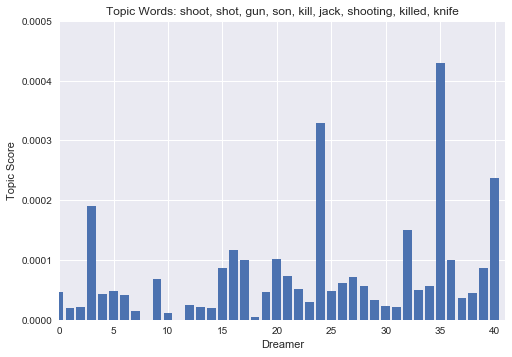

In [99]:
#==================================================================
# Cell Purpose: Provide topic # of interest below for n
#==================================================================
n = 52
print "Topic: " + str(n)
print AllTopics[n].keys()
TopicScores = ScoreEveryone(AllTopics[n])
# print TopicScores.sort_values("W266ID", ascending = True)["NormalizedScore"].to_string(index=False)
plot_topics(AllTopics[n].keys())

In [ ]:
top_topics = dreamerLdaModel.top_topics(corpus, topn=20)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / len(dreamerLdaModel.get_topics())
print('Average topic coherence: %.4f.' % avg_topic_coherence)

from pprint import pprint
pprint(top_topics)

In [ ]:
# Print a few of the most 
print dreamerLdaModel.print_topics(-1)

In [ ]:
#==================================================================
# Cell Purpse: 1)Take a dreamer from the Collection
#              2) Create a BOW for each dream
#              3) Create the LDA_Vector 
#              4) Compute the top topics per dreaml
#================================================================== 

# Take Dreamer i and transform the dreams into a bow
# cell_start = time.time()
DEBUG_VERBOSITY_HIGH = False


text = "The one at the Meads's house, where it's bigger inside than out; there's a European village just inside, with a cobblestone street and a Pied-Piper sort of man with curly hair, he can do things like juggle - I go up the back stairs [there aren't any in the real house] and then down the other side [since there's a second set, immediately] then down a short empty hallway that turns a corner, where I find a tiny room...a young woman with shoulder-length blonde hair in a pageboy is there, cooking at a stove that almost fills the room...she's nice to me. Now outside, I'm waiting for my aunt to pick me up - she arrives in a little round convertible and we go for a drive, not very far - we cross a little bridge over a creek, then double back and she drops me off at the house again. Inside (?) I sit with a couple of people, playing with a string of blue balloons."
#bow_vector = dictionary.doc2bow(dream)
bow_vector = dictionary.doc2bow(nltk.tokenize.word_tokenize(text))
bow_vector2 = dictionary.doc2bow(dreams[1])
lda_vector = dreamerLdaModel[bow_vector2]   # topic probability distribution
print lda_vector
print dreamerLdaModel.print_topic(max(lda_vector, key=lambda item: item[1])[0])


if DEBUG_VERBOSITY_HIGH:
    print len(bow_vector2)
    #print bow_vector2
    print [(dictionary[id], count) for id, count in bow_vector2]
    print "\n"
    print len(bow_vector)
    print [(dictionary[id], count) for id, count in bow_vector]
    

In [ ]:
lda_vector = dreamerLdaModel[bow_vector]
# print lda_vector 
print dreamerLdaModel.print_topic(max(lda_vector, key=lambda item: item[1])[0])

# Author Topic Modeling 
Reference: https://nbviewer.jupyter.org/github/rare-technologies/gensim/blob/develop/docs/notebooks/atmodel_tutorial.ipynb

In [75]:
#==================================================================
# Cell Purpse: Create author2doc
#              mapping of authors to dreamIDs/docIDs
#================================================================== 
author2doc = dict()

for docID in range(len(df)):
    authorID = df['W266ID'][docID]
    if not author2doc.get(authorID):
        # This is a new author.
        author2doc[authorID] = []
    
    # Add document IDs to author
    author2doc[authorID].extend([docID])        

In [76]:
#==================================================================
# Cell Purpse: Load previously trained Author Topic Model 
#              or else train Author Topic Model 
#================================================================== 
from gensim.models import AuthorTopicModel

CREATE_FULL_CORPUS_AUTHOR_MODEL = False

if CREATE_FULL_CORPUS_AUTHOR_MODEL:
    
    model_list = []
    for i in [50,100,150,200]:
        model_path = './model/authorModels/AuthorLDA'+str(i)+'.model'
        %time AuthorModel = AuthorTopicModel(corpus=corpus, num_topics=i, id2word=dictionary.id2token, \
                                    author2doc=author2doc, chunksize=2600, passes=100, eval_every=None, \
                                    iterations=400, alpha='auto', eta='auto')
        top_topics = AuthorModel.top_topics(corpus)
        tc = sum([t[1] for t in top_topics])
        model_list.append((AuthorModel, tc))
        AuthorModel.save(model_path)
    
else: 
    model_list = []
    #for i in [50,100,150,200]:
    for i in [50]:
        model_path = './model/authorModels/AuthorLDA'+str(i)+'.model'
        AuthorModel = AuthorTopicModel.load(model_path)
        top_topics = AuthorModel.top_topics(corpus)
        tc = sum([t[1] for t in top_topics])
        model_list.append((AuthorModel, tc))
print "model_list is:\t", len(model_list)
model, tc = max(model_list, key=lambda x: x[1])
print('Best model topic coherence: %.3e' %tc)        

model_list is:	1
Best model topic coherence: -6.142e+02


In [26]:
# Example topic. It doesn't look useful/helpful
#print len(model.show_topic())
print model_list

[(<gensim.models.atmodel.AuthorTopicModel object at 0x0000000022EC7438>, -614.21579704039357)]


In [77]:
for topic in model.show_topics(num_topics=20):
    print "Topic:", topic[0]
    words = ''
    for word, prob in model.show_topic(topic[0]):
        words += word + ' '
    print 'Words: ' + words 
    print
top_topics = model.top_topics(corpus, topn=20)    
#print (top_topics)

Topic: 17
Words: she for her some about from had one they then 

Topic: 40
Words: she for her some about from had one they then 

Topic: 36
Words: she for her some about from had one they then 

Topic: 32
Words: she for her some about from had one they then 

Topic: 45
Words: she for her some about from had one they then 

Topic: 24
Words: she for her some about from had one they then 

Topic: 16
Words: she for her some about from had one they then 

Topic: 29
Words: she for her some about from had one they then 

Topic: 30
Words: she for her some about from had one they then 

Topic: 39
Words: she for her some about from had one they then 

Topic: 15
Words: had some were later about patient woman mother man hospital 

Topic: 10
Words: were had said this went guy some got then something 

Topic: 38
Words: this were had some sort they very about going something 

Topic: 49
Words: were said had saw then came him out looked one 

Topic: 41
Words: this not get are have they for like some o

In [78]:
def show_author(name):
    print('\nDreamerID:%d' % name)
    print('Topics:')
    pp=pprint.PrettyPrinter(indent=4)
    pp.pprint([(topic[0], topic[1]) for topic in model[name]])

In [79]:
for i in range(0,40):
    show_author(i+1)


DreamerID:1
Topics:
[   (13, 0.077470633554747315),
    (14, 0.050693620757122054),
    (19, 0.048697299104955259),
    (37, 0.11245753439696292),
    (38, 0.070772838140230068),
    (41, 0.56483675739314265),
    (43, 0.055941617724067735),
    (49, 0.014277067575665138)]

DreamerID:2
Topics:
[   (13, 0.20985876502597384),
    (14, 0.044608338826435723),
    (19, 0.28914749959226288),
    (37, 0.17820329474407884),
    (38, 0.045549401901240988),
    (41, 0.07522727666760641),
    (43, 0.056245928328326429),
    (49, 0.10114590619374504)]

DreamerID:3
Topics:
[   (13, 0.083024079878078208),
    (14, 0.1445717913945842),
    (19, 0.10333582560817473),
    (25, 0.015092024689970051),
    (37, 0.15573573177838934),
    (38, 0.068339669372582526),
    (41, 0.15912739142778265),
    (43, 0.23885145757549392),
    (49, 0.029988483671498114)]

DreamerID:4
Topics:
[   (13, 0.073440393753700137),
    (14, 0.052975713496328521),
    (19, 0.037324482178531508),
    (37, 0.30629484383306105),
  

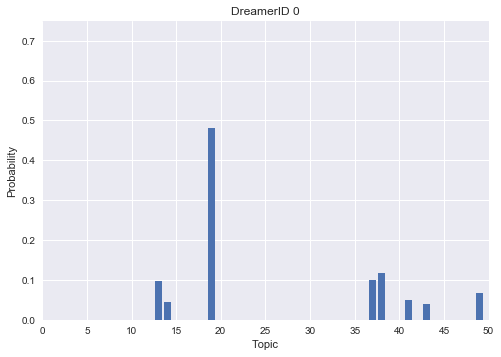

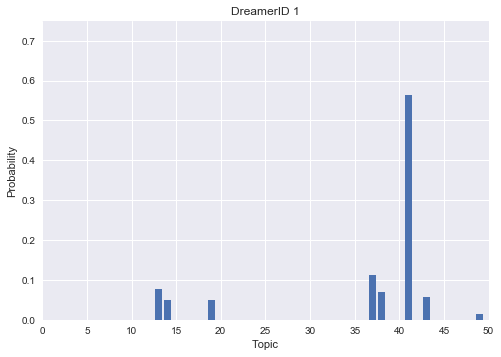

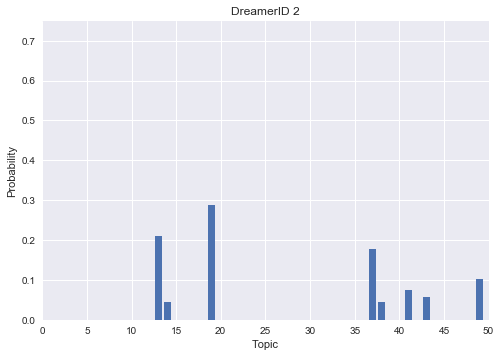

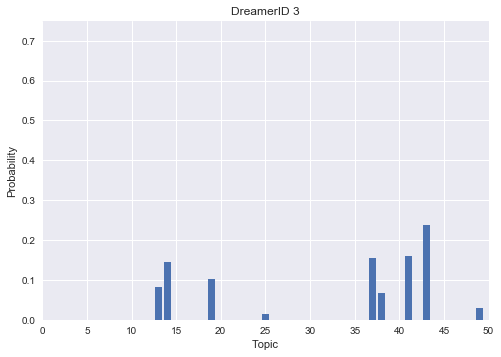

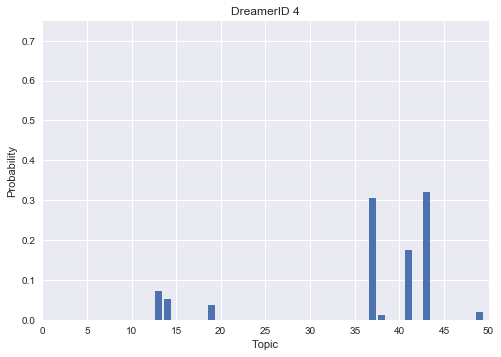

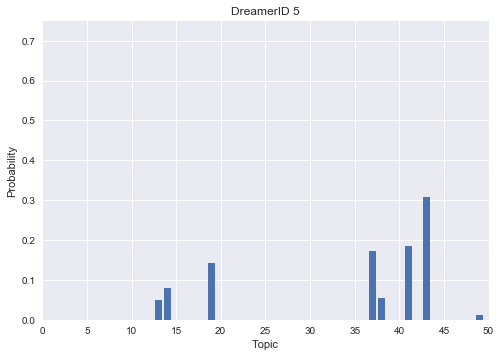

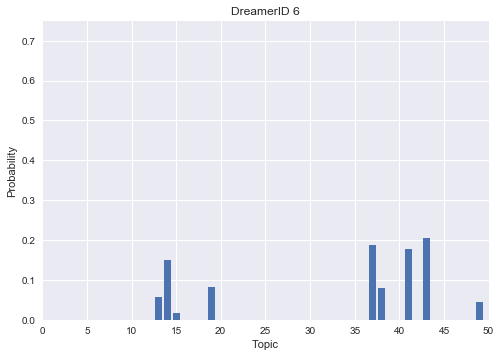

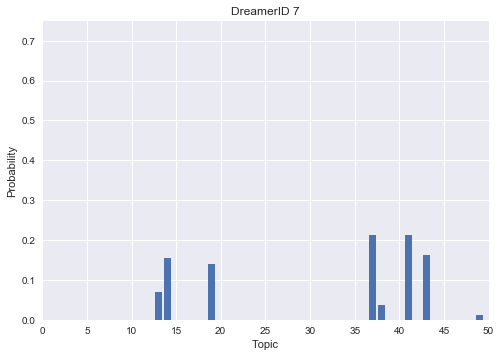

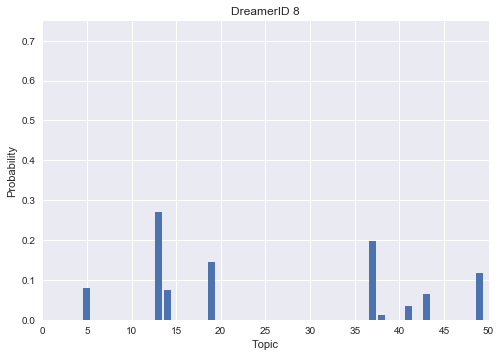

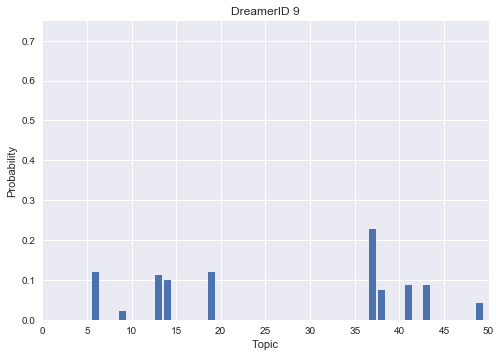

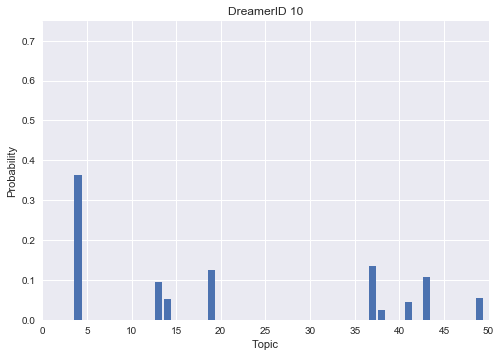

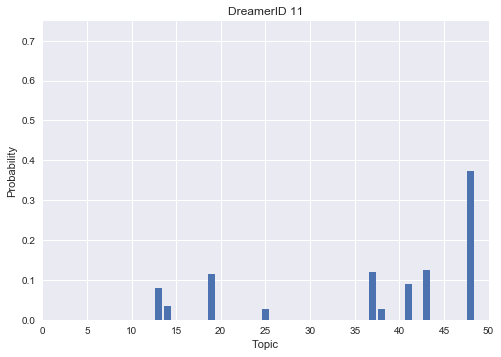

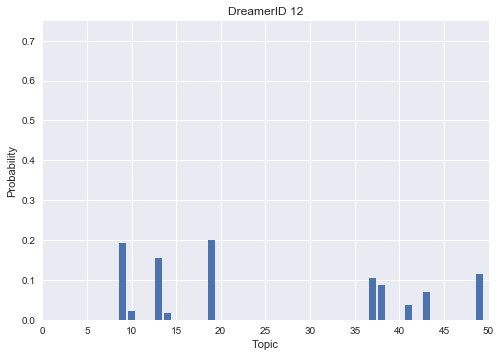

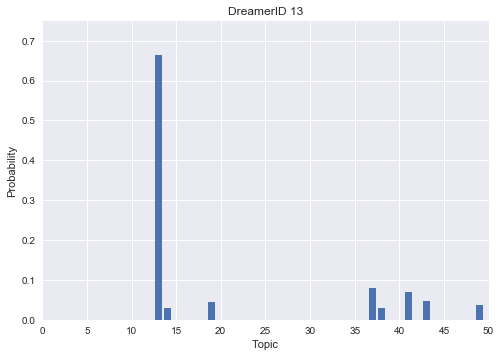

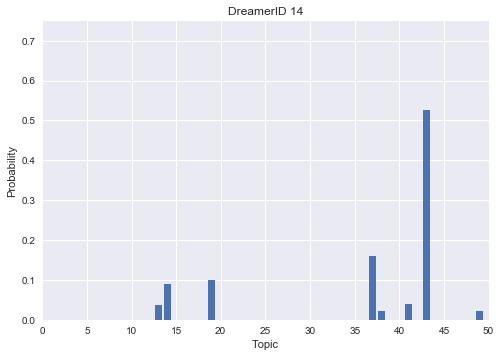

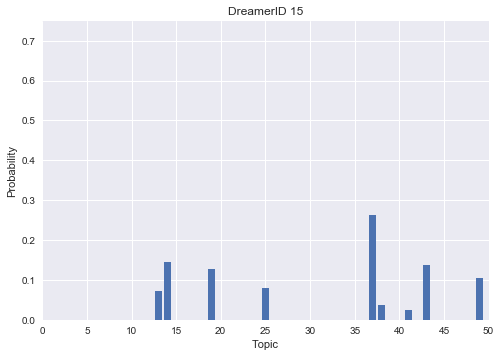

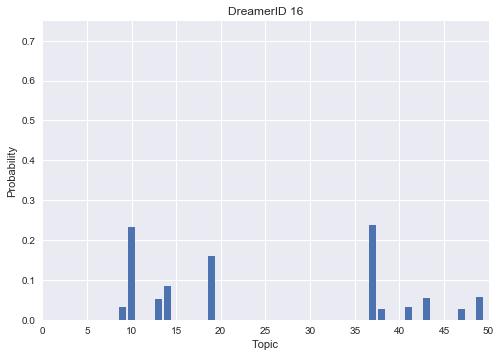

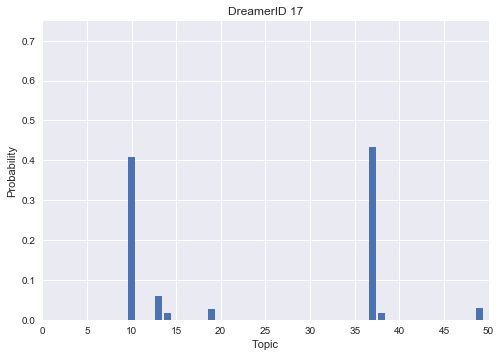

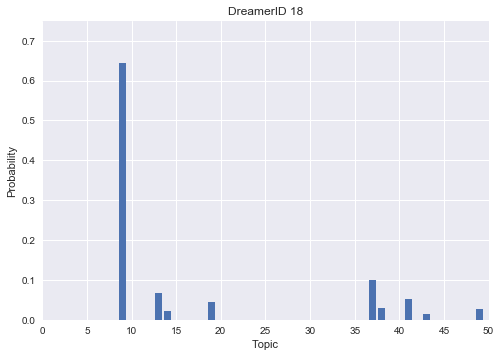

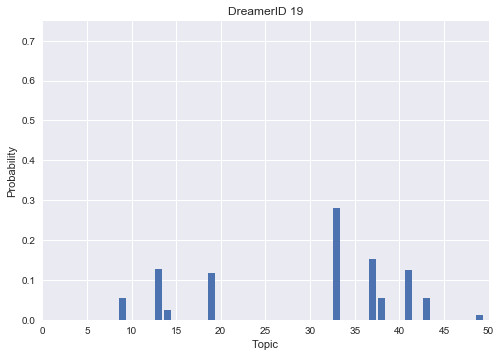

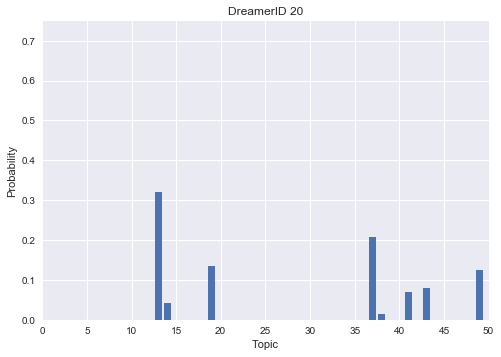

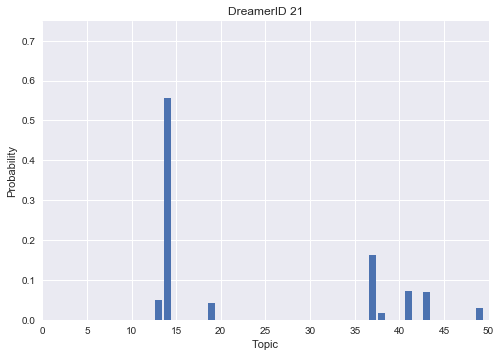

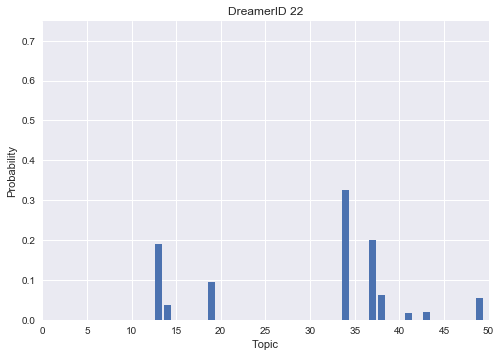

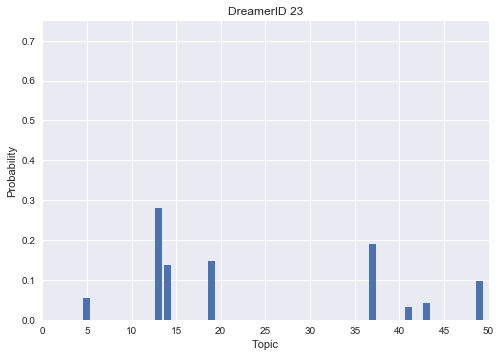

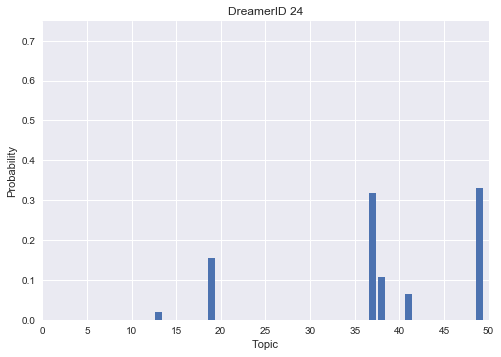

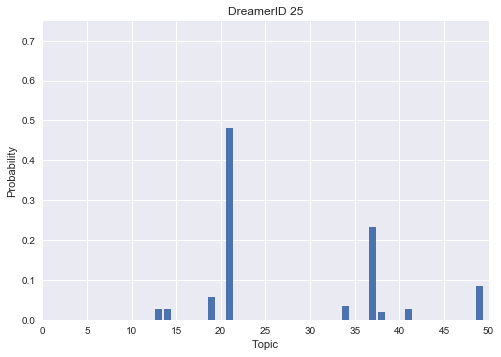

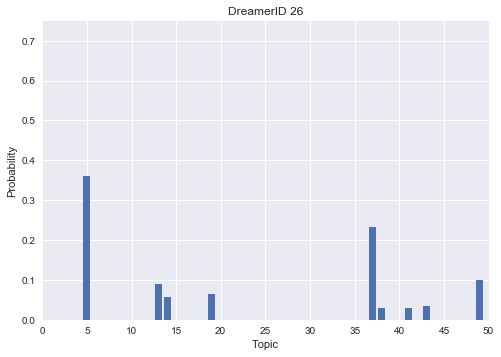

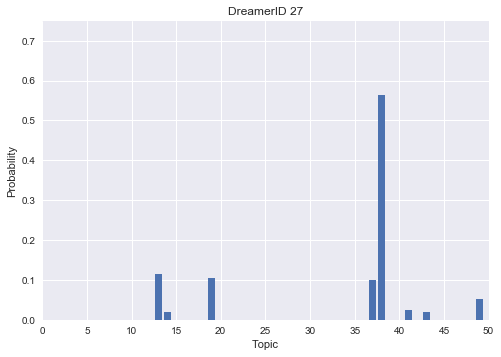

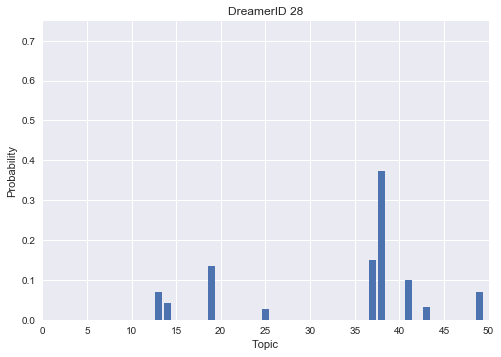

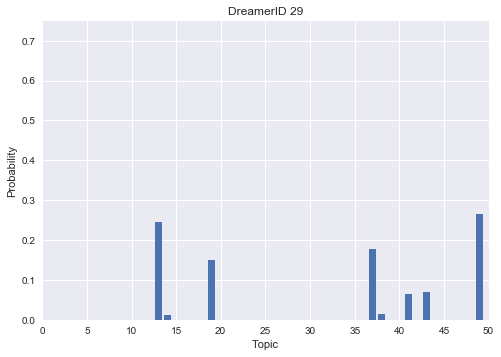

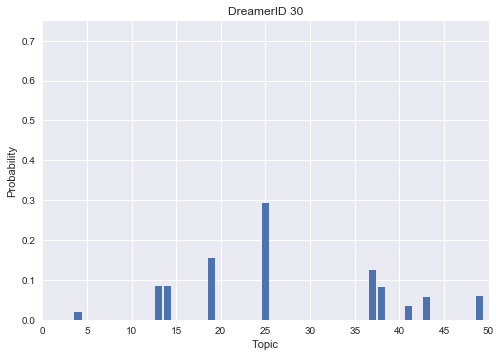

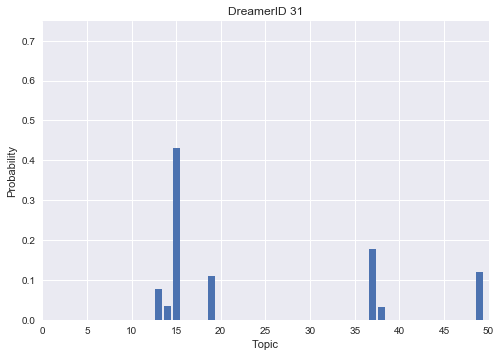

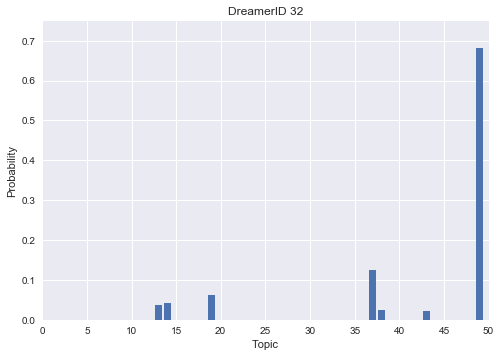

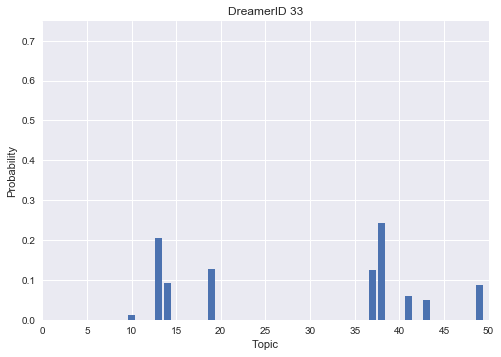

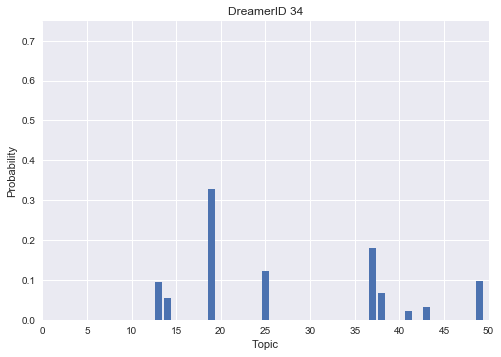

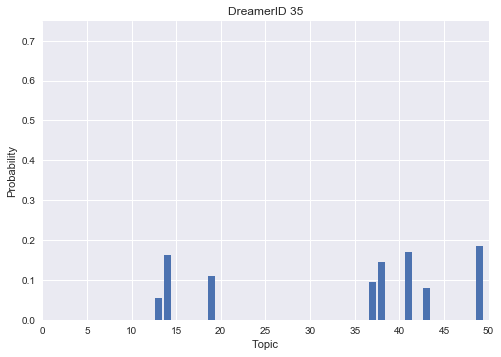

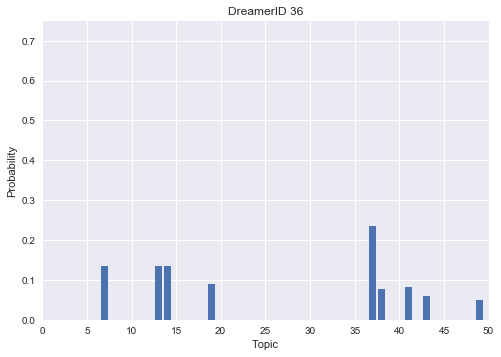

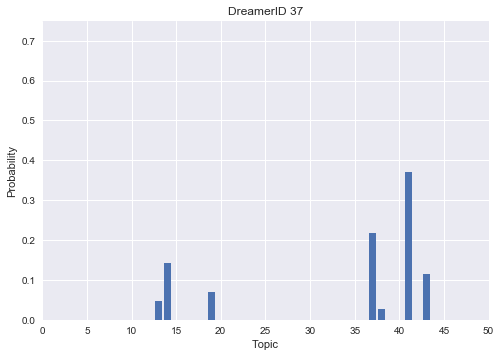

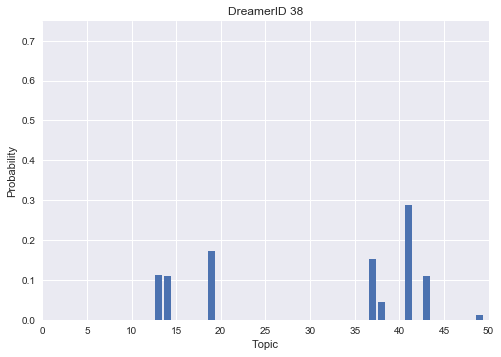

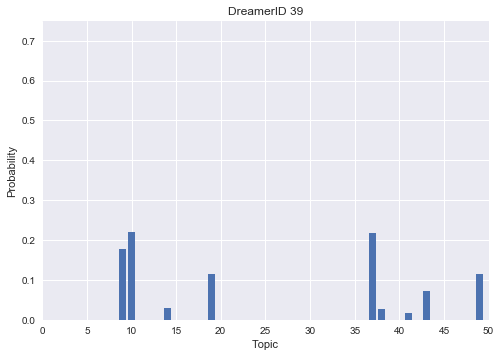

In [87]:
def plot_author_topics(name):

    x,y = zip(*model[name])
    dreamerLabelText = "DreamerID " + str(name)
    plt.style.use('seaborn')
    axis_ticks = np.arange(0,51,5)
    plt.xlabel("Topic")
    plt.ylabel("Probability")
    plt.title(dreamerLabelText)
    plt.xlim((0,50))
    plt.ylim((0,0.75))
    
    plt.xticks(axis_ticks)
    plt.bar(x,y) 
    plt.show()

for i in range(0,40):
    plot_author_topics(i)    

In [82]:
from gensim.similarities import MatrixSimilarity

# Generate a similarity object for the transformed corpus.
index = MatrixSimilarity(model[list(model.id2author.values())])

In [83]:
# Get similarities to some author.
def get_table(author_id, top_n=10, smallest_author=1):
    '''
    Get table with similarities, author IDs, and author sizes.
    Return `top_n` authors as a dataframe.   
    '''
    
    # Get similarities.
    sims = index[model[author_id]]

    # Arrange author names, similarities, and author sizes in a list of tuples.
    table = []
    for elem in enumerate(sims):
        author_name = model.id2author[elem[0]]
        sim = elem[1]
        author_size = len(model.author2doc[author_name])
        if author_size >= smallest_author:
            table.append((author_name, sim, author_size))
            
    # Make dataframe and retrieve top authors.
    df = pd.DataFrame(table, columns=['AuthorID', 'Cosine Distance', 'Size'])
    df = df.sort_values('Cosine Distance', ascending=False)[:top_n]
    
    return df

In [84]:
# authors most similar to Dreamer #1
for i in range(0,40):
    print "Dreamer Number ", (i)
    print (get_table(i, top_n=20))
    print "\n"

Dreamer Number  0
    AuthorID  Cosine Distance  Size
0          0         1.000000  4075
34        34         0.911037    86
2          2         0.881176    48
12        12         0.741533    19
33        33         0.666018   506
38        38         0.631194    27
8          8         0.625510    24
23        23         0.615834    38
9          9         0.615532   166
28        28         0.607302   128
29        29         0.606500    44
35        35         0.589425    16
20        20         0.587796    42
15        15         0.585503    72
16        16         0.581842   110
7          7         0.581666    75
30        30         0.566792   234
24        24         0.555471    23
36        36         0.539273    63
5          5         0.537073    53


Dreamer Number  1
    AuthorID  Cosine Distance  Size
1          1         1.000000   422
37        37         0.911805    33
38        38         0.857504    27
7          7         0.728969    75
6          6         0.675

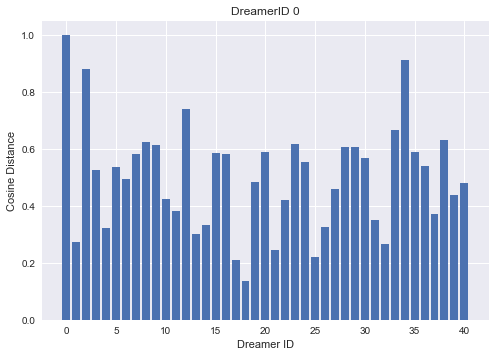

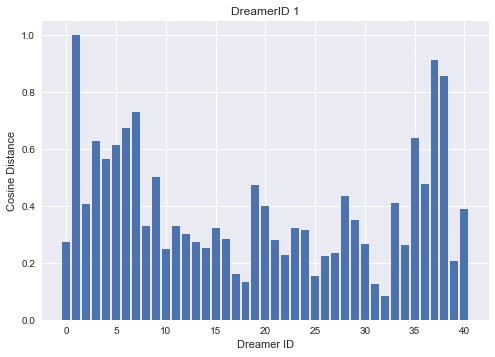

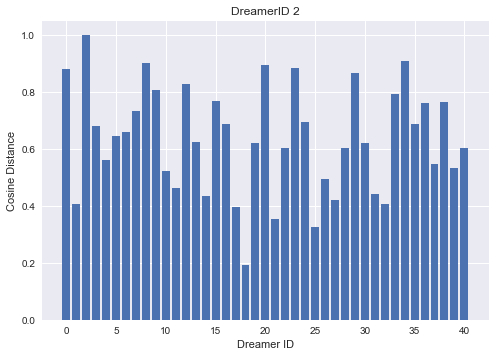

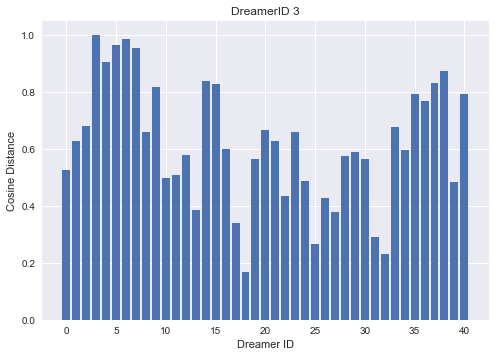

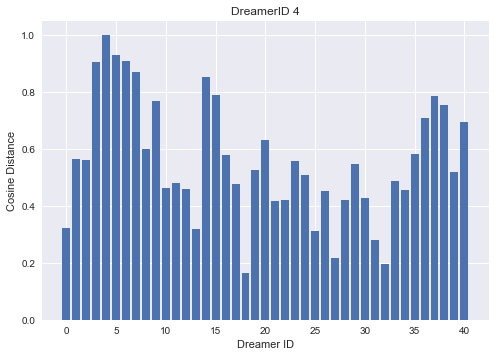

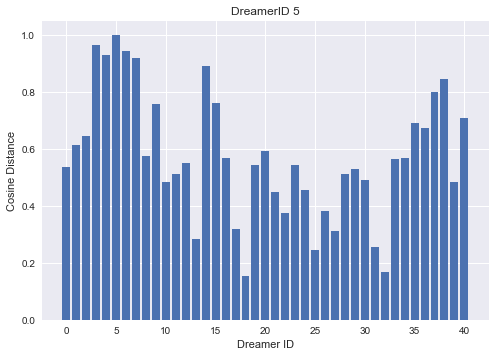

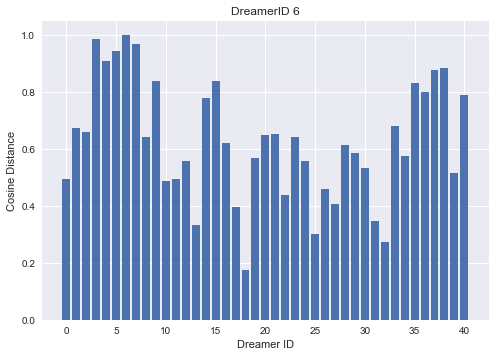

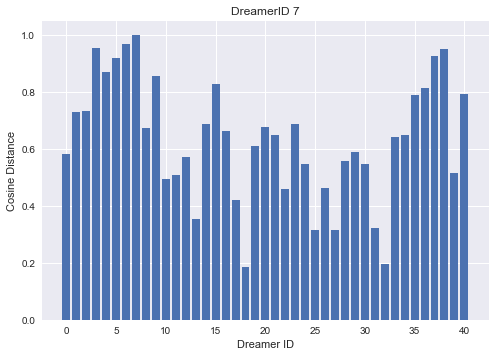

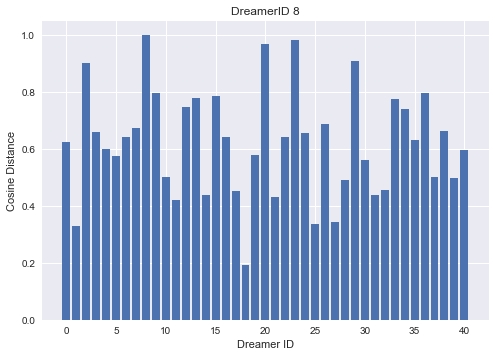

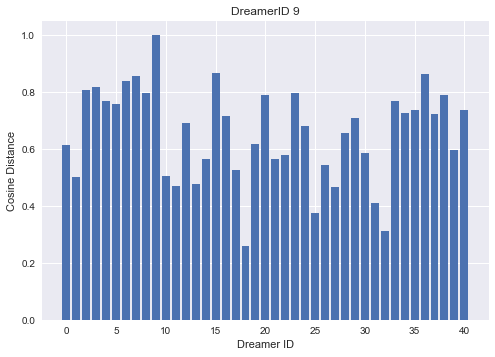

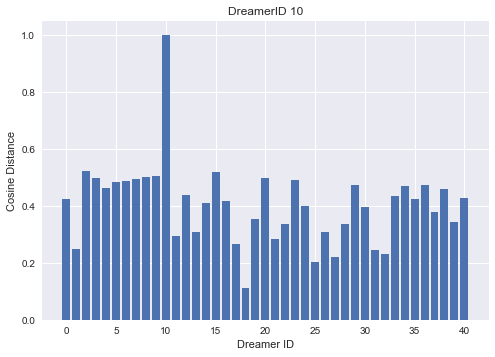

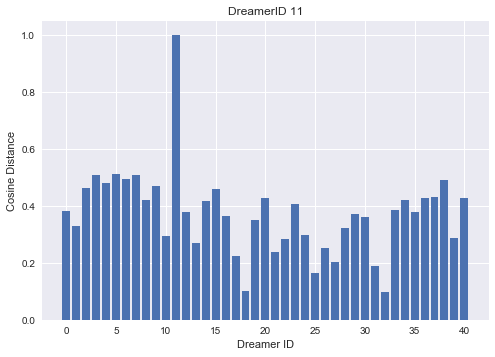

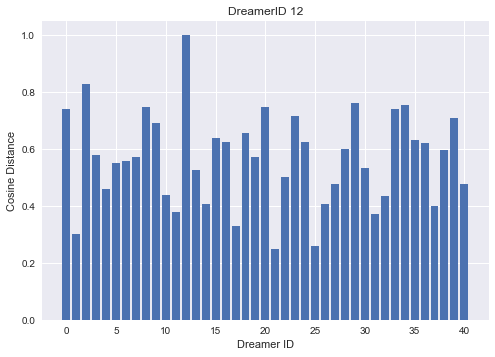

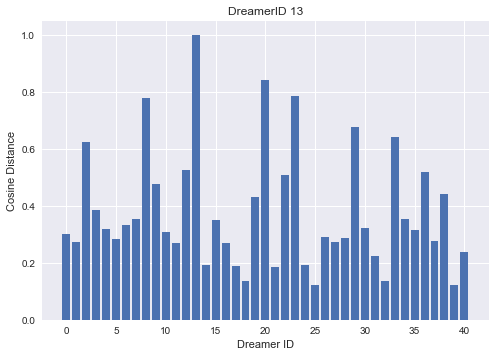

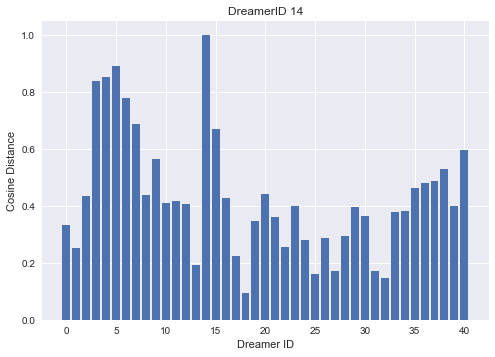

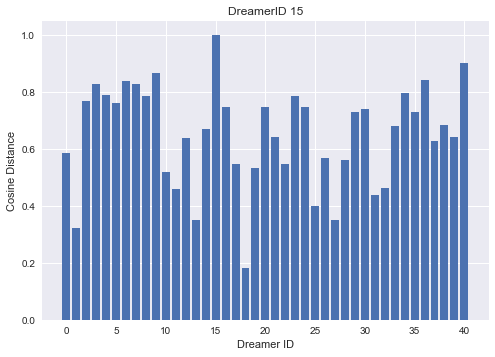

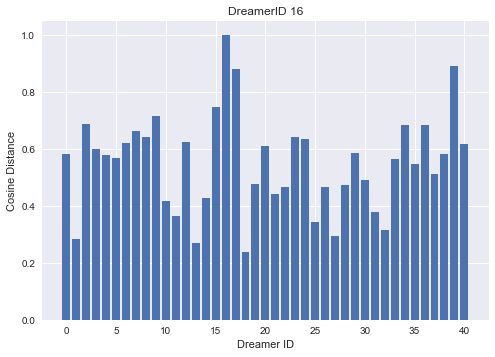

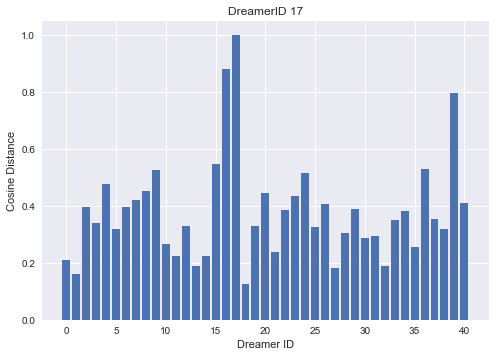

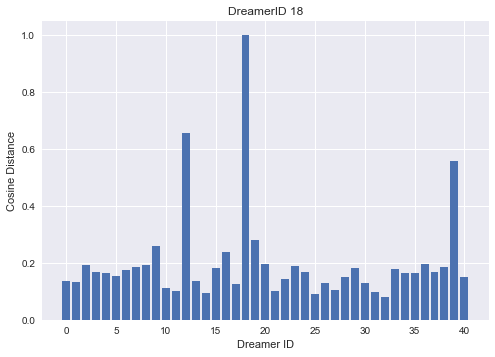

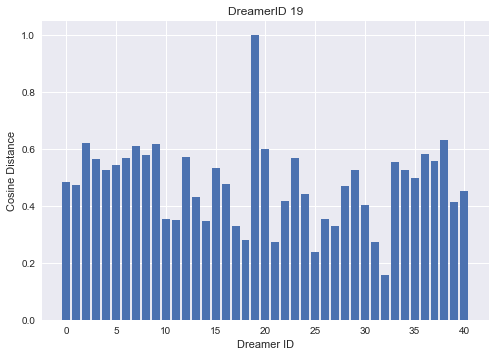

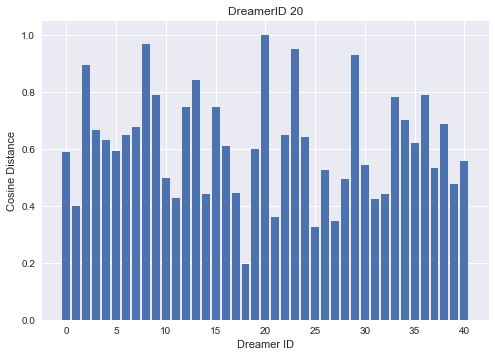

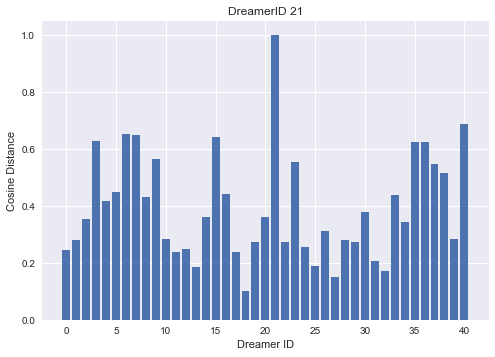

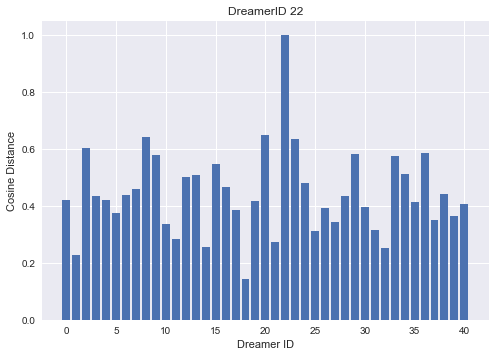

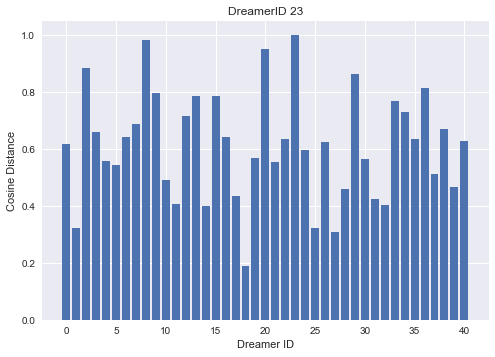

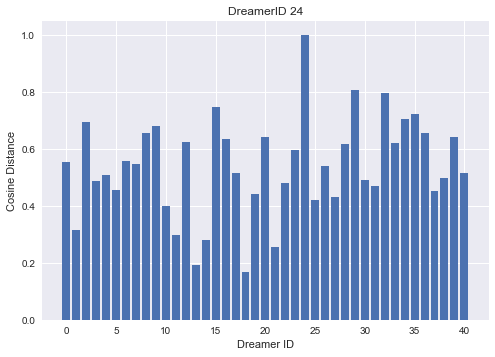

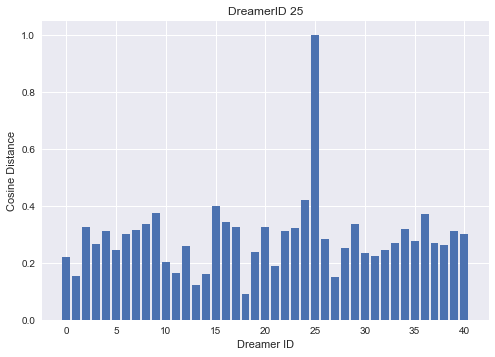

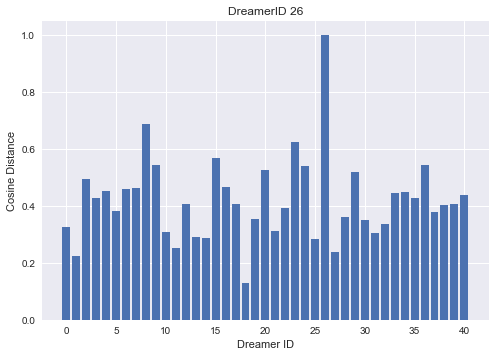

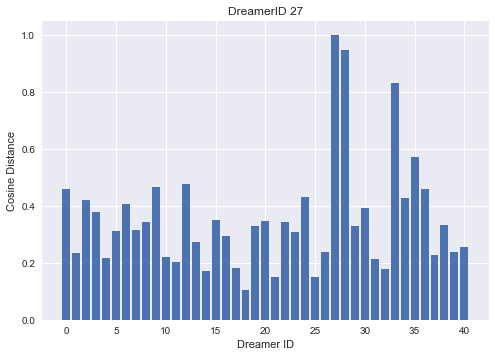

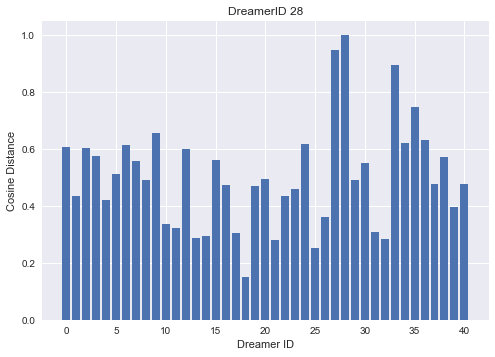

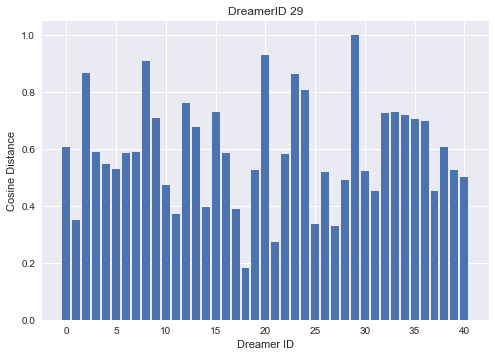

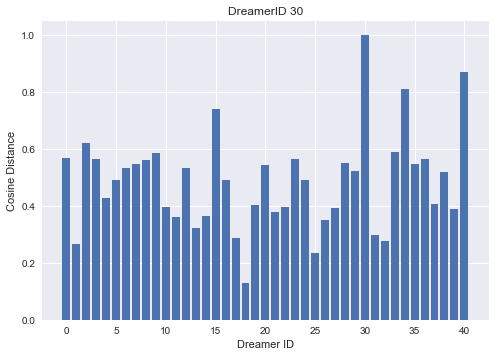

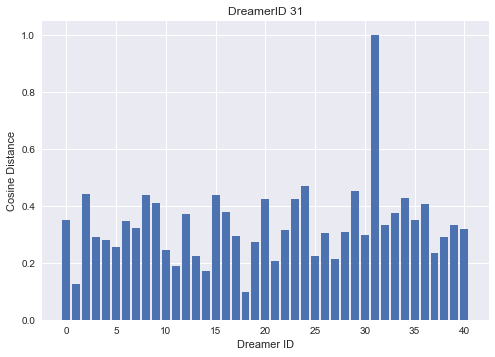

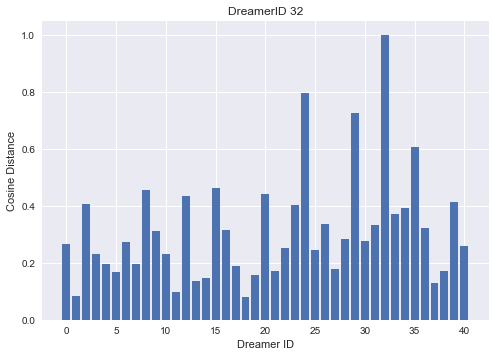

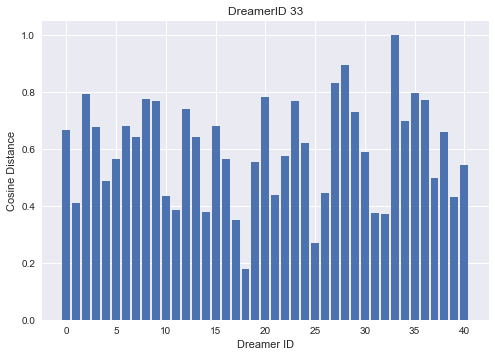

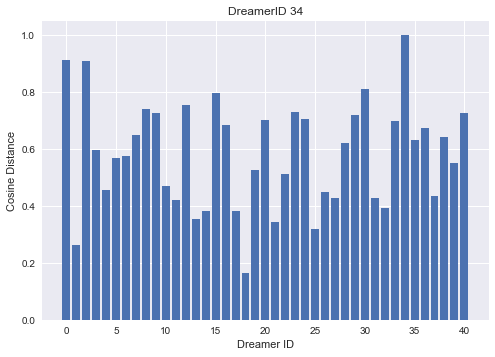

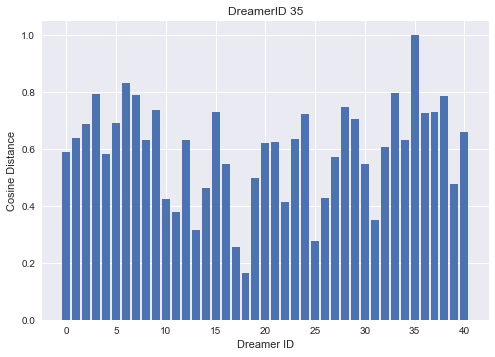

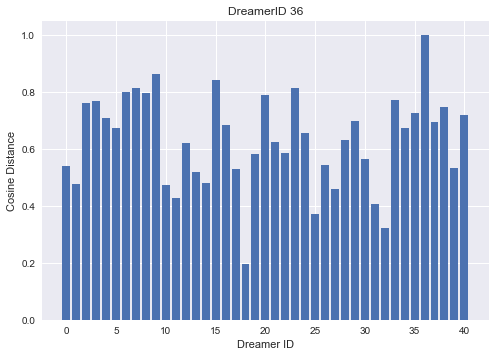

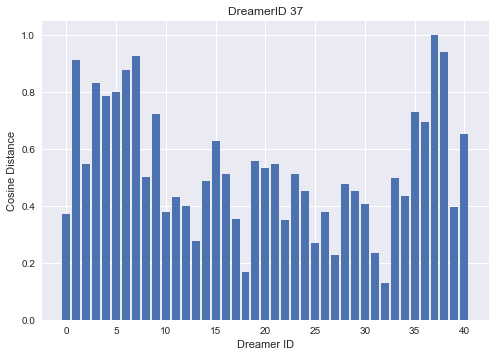

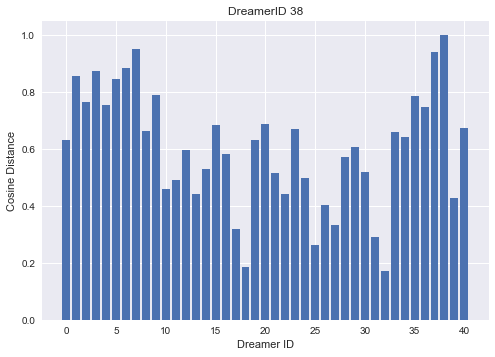

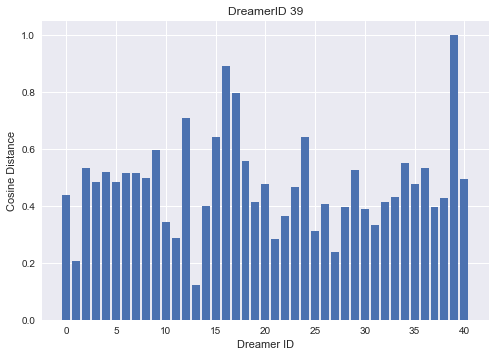

In [88]:
def plotCosineDist(name, numTopMatches):

    df = get_table(name, top_n=numTopMatches)
    dreamerLabelText = "DreamerID " + str(name)

    X = df['AuthorID'].values
    Y = df['Cosine Distance'].values
    plt.style.use('seaborn')
    plt.title(dreamerLabelText)
    plt.xlabel("Dreamer ID")
    plt.ylabel("Cosine Distance")
    plt.bar(X,Y) #, color='blue')
    plt.show()

for i in range(0,40):
    plotCosineDist(i, 41)

# Latent Semantic Indexing (LSI, LSA) 
Use a TfIDF-weighte space and create a model
